## Identificando Agregação Espaço-Temporal
Werneck, Guilherme L., e Claudio J. Struchiner. “Estudos de agregados de doença no espaço-tempo: conceitos, técnicas e desafios”. Cadernos de Saúde Pública 13, nº 4 (outubro de 1997): 611–24. https://doi.org/10.1590/S0102-311X1997000400005.

> "Agregação espaço-temporal pode ser entendida como uma forma de não-aleatoriedade na distribuição da doença : em que, entre eventos próximos no tempo, existe um excesso não esperado de eventos que estão também próximos no espaço (McAullife & Afifi, 1984). Este conceito é distinto do de agregação espacial e temporal, e também tem sido denominado interação espaço-temporal (Knox, 1991; Jacquez et al., 1996). De fato, agregação espaço-temporal pode ocorrer na ausência de agregação espacial e temporal, ou mesmo estar ausente quando existe agregação nas duas dimensões (Estève et al., 1994)."

Seguindo o exemplo da publicação são criadas algumas visualizações a seguir para identificar agregação espaço-temporal.

São necessárias formas geométricas adquiridas no site do IBGE (apenas .shp, .shx e .dbf):

- https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2020/Brasil/BR/BR_Municipios_2020.zip
- Descompactar em data/



In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt

In [13]:
def load_data():
    df = pd.read_csv(
        '../data/indicadores/visceral/indicador_15_taxa_incidencia_municipio_infeccao.csv'
    ).set_index('CO_MN_INF')
    mun = pd.read_csv('../data/processed/municipios.csv')    
    # *.shp vai utilizar o arquiv .shx e .dbf 
    shapes = gpd.read_file('../data/BR_Municipios_2020.shp')
    shapes.CD_MUN = shapes.CD_MUN.apply(lambda x: x[0:6])
    shapes.CD_MUN = shapes.CD_MUN.astype(int)
    shapes = shapes.set_index('CD_MUN')
    df['geometry'] = df.index.map(shapes['geometry'].to_dict())
    return df, mun

def spatial_agregation():
    para = data.loc[mun.loc[mun.estado == 'Pará', 'ibge_code'], :]
    para['acumulado'] = para.loc[:, anos].mean(axis=1)
    para = para.drop(anos, axis=1)
    #para = para.loc[para.acumulado > data.mean(axis=1).mean(), :]
    #para['acumulado'] = (para.acumulado - para.acumulado.min()) / (para.acumulado.max() - para.acumulado.min())

    gdf = gpd.GeoDataFrame(para.replace(0, np.nan), geometry='geometry', crs="EPSG:4326")

    ax = gdf.plot(
        column='acumulado', 
        cmap = plt.cm.Oranges, figsize=(15,9),   
        scheme='quantiles', 
        k=8, 
        legend = True,
        missing_kwds={
            'color': 'white',
            'edgecolor': 'gray',
            'hatch': '///',
            'label': 'Sem casos registrados'
        },
    )
    ax.set_title(
        '''Incidência média dos municípios - 2007 a 2019
        Média aritmética simples''', 
        fontdict = {'fontsize':22}
    )
    ax.set_axis_off()
    #move legend to an empty space
    ax.get_legend().set_bbox_to_anchor((.12,.12))
    plt.show()
    #display(mapclassify.Quantiles(gdf.acumulado, k=8))
    
def temporal_agregation():
    para = data.loc[mun.loc[mun.estado == 'Pará', 'ibge_code'], anos].mean(axis=0)

    #se aumentou mais que 50% em relação a media de todos anos (critério aleatório)
    clrs = ['red' if x == True else 'blue' for x in (para / para.mean() > 1.5).values]
    ax = para.plot(
        kind='bar',
        figsize=(15,9),
         color=clrs
    )
    ax.set_title(
        '''Incidência média dos municípios - 2007 a 2019
        Média aritmética simples''', 
        fontdict = {'fontsize':22}
    )
    plt.show()
    
def spatial_temporal_agregation():
    idx = mun.loc[(mun.estado == 'Pará'), ['ibge_code', 'mesorregiao']].set_index('ibge_code')['mesorregiao'].to_dict()
    para = data.loc[mun.loc[mun.estado == 'Pará', 'ibge_code'], :]
    para['mesorregiao'] = para.index.map(idx)

    group = para.groupby('mesorregiao').mean()

    fig, ax = plt.subplots(1, figsize=(16, 6))
    plt.legend(
        tuple(plt.bar(anos, group.loc[it, :])[0] for it in group.index), (group.index), fontsize=12, ncol=4, framealpha=0, fancybox=True
    )
    ax.set_title(
        '''Incidência média dos municípios - 2007 a 2019
        Média aritmética simples''', 
        fontdict = {'fontsize':22}
    )
    #move legend to an empty space
    ax.get_legend().set_bbox_to_anchor((0.9,1.5))
    plt.show()

## Carregando Dados
- df: arquivo de taxa de incidência (2007-2019)
- shapes e mun: formas (polígonos) para criação de mapas e informações sobre municípios

In [3]:
data, mun = load_data()

In [4]:
anos = data.columns[0:-1]

### Existe agrupamento espacial?
- mapa cloropleth da incidência média acumulada de cada município

Existem municípios próximos (vizinhos) que possuem taxa média de incidência acumulada semelhantes nos 13 anos. 

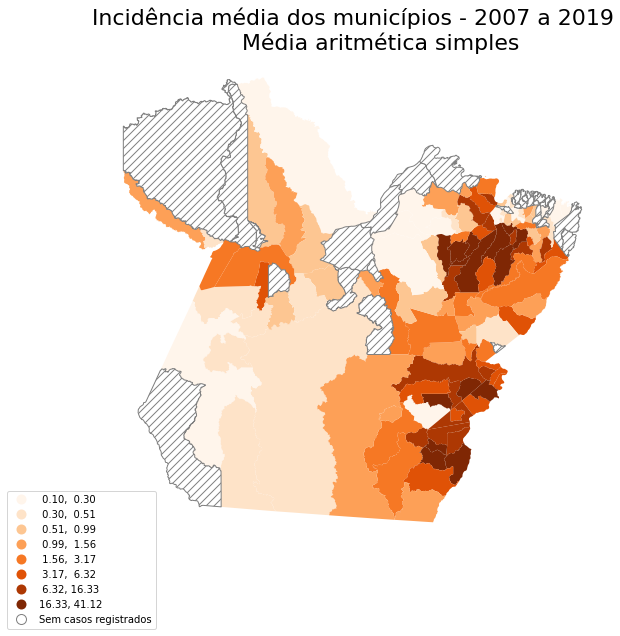

In [5]:
spatial_agregation()

### Existe agrupamento temporal?
- gráfico de barras da incidência média anual do estado (média aritmética simples da incidência de todos municípios em cada ano)

- Percebe-se que há um comportamento de clustering nos anos 2017 e 2018.

O critério de identificação adotado é visual no artigo.

O critério quantitativo aleatório escolhido foi: se o período apresentar aumento de pelo menos 50% em relação a média geral (de todos os anos)

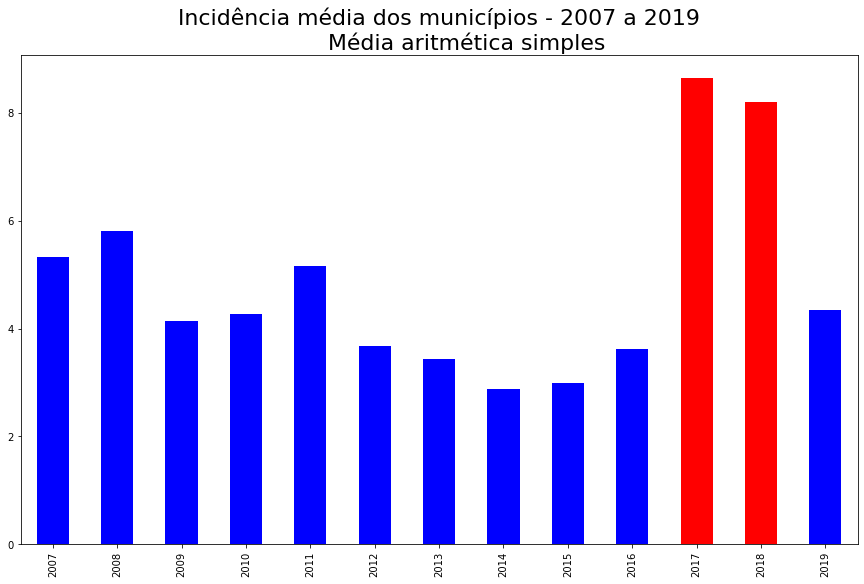

In [6]:
temporal_agregation()

### Existe agrupamento espaço-temporal?
- gráfico de barras empilhado da incidência média anual de cada mesorregião do estado.

- Foi divido em mesorregiões para melhor visualização, visto que no primeiro mapa foi identificada tendência de agrupamentos em regiões próximas


- Região Sudeste apresenta agregação no espaço (as maiores taxas de incidência numa mesma região) e no tempo (principalmente nos anos 2017 e 2018.


- Metropolitana de Belém começa com a maior taxa e é drasticamente reduzida após 2009.
- Nordeste Paraense começa com a segunda maior taxa e é drasticamente reduzida após 2011.
- O Sudeste apresenta comportamento ascendente contínuo e domina, com as maiores taxas de incidência, a partir de 2012.

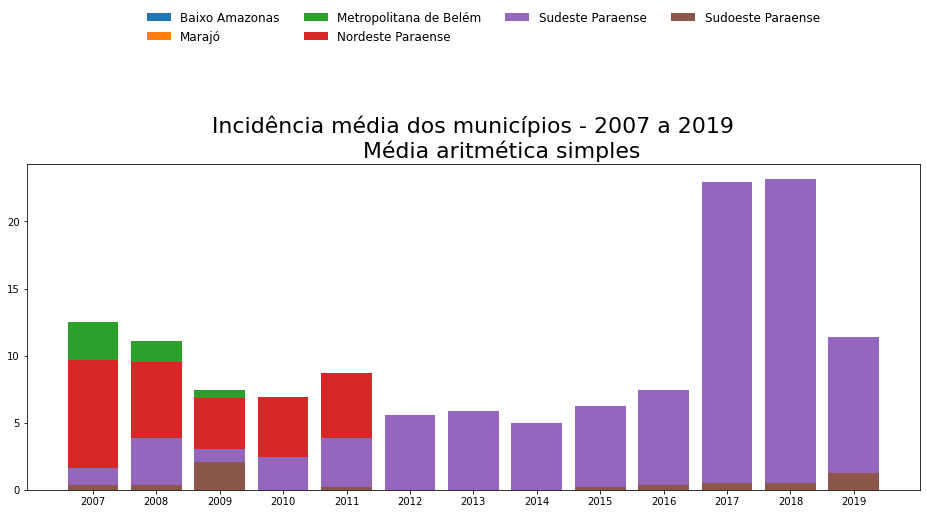

In [12]:
spatial_temporal_agregation()

## Testes Estatísticos

__Besag & Newell (1991), as técnicas para investigação de agregados espaciais e temporais podem ser divididas em dois subgrupos:__
- `testes de agregação (T1)`
    - gerais (T1-G): objetivam identificar um padrão geral de distribuição da doença em uma grande região.
    - focais (T1-F)
- `testes para detecção de agregados (T2)`
    - "são utilizados na vigilância rotineira de grandes quantidades de pequenas áreas, buscando evidenciar agregados pontuais de doença, porém sem preconcepção acerca de suas localizações."
    
    
__Técnicas avaliadas no artigo:__ 

- `Knox (Knox, 1964a)`,
- `Mantel (Mantel, 1967)`, 
- `McAuliffe (McAuliffe & Afifi, 1984)`, 
- `EMM (Ederer et al., 1964)`
- `Moran (Moran, 1948; Moran, 1950; Cliff & Ord, 1981)`

__As notificações não possuem coordenadas, das técnicas acima se encaixam as de testes de agregação `T1`:__
- `EMM`
- `Moran`

Observação: o artigo traz uma fórmula de Moran adaptada para análise de agregação espaço temporal.

## Assessing Global Spatial Autocorrelation
We calculate Moran's I. A test for global autocorrelation for a continuous attribute.

- Fonte: 
    - [download notebook:](http://pysal.org/notebooks/content/viz/splot/esda_morans_viz.ipynb)
    - [web page:](http://pysal.org/notebooks/viz/splot/esda_morans_viz.html)

In [66]:
from libpysal.weights.contiguity import Queen
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from esda.moran import Moran

In [31]:
para = data.loc[mun.loc[mun.estado == 'Pará', 'ibge_code'], :]

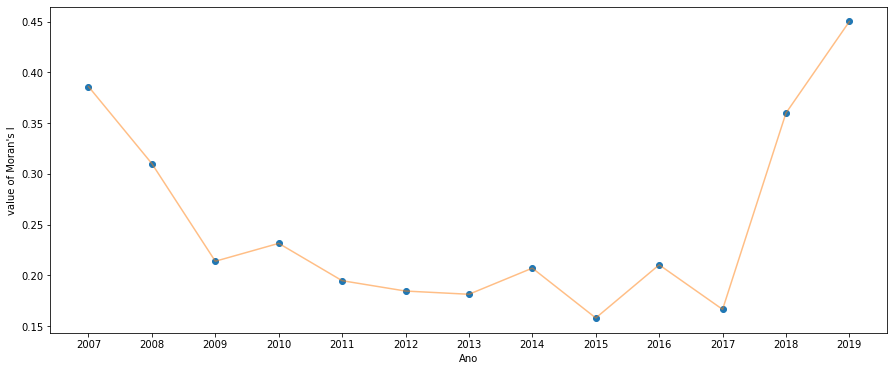

In [60]:
I = {}
for it in anos:
    y = para.loc[:, it].values
    w = Queen.from_dataframe(para)
    w.transform = 'r'
    moran = Moran(y, w)
    I.update({it: moran.I})
plt.figure(1 , figsize = (15 ,6))
plt.plot(I.keys() , I.values() , 'o')
plt.plot(I.keys() , I.values() , '-' , alpha = 0.5)
plt.xlabel('Ano') , plt.ylabel("value of Moran's I")
plt.show()

In [62]:
y = para.loc[:, '2019'].values
w = Queen.from_dataframe(para)
w.transform = 'r'
moran = Moran(y, w)

In [69]:
moran.I, moran.p_sim

(0.45015038934247004, 0.001)

Our value for the statistic is interpreted against a reference distribution under the null hypothesis of complete spatial randomness. PySAL uses the approach of random spatial permutations.

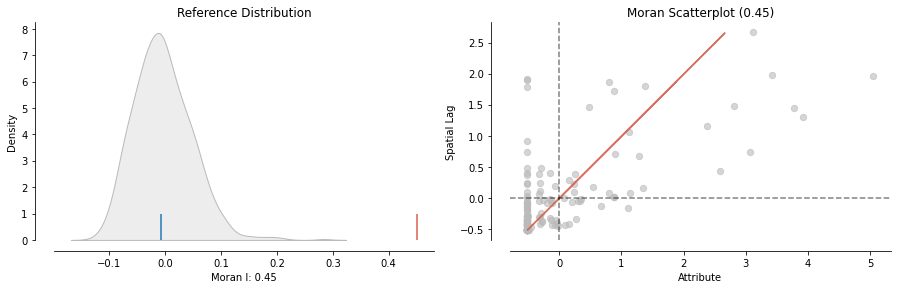

In [68]:
plot_moran(moran, zstandard=True, figsize=(15,4))
plt.show()

## Visualizing Local Autocorrelation with splot - Hot Spots, Cold Spots and Spatial Outliers
In addition to visualizing Global autocorrelation statistics, splot has options to visualize local autocorrelation statistics. We compute the local Moran `m`. Then, we plot the spatial lag and the Donatns variable in a Moran Scatterplot.

In [85]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation

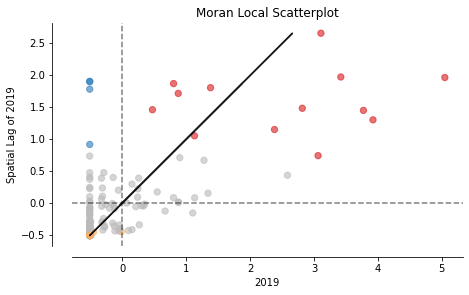

In [75]:
# calculate Moran_Local and plot
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('2019')
ax.set_ylabel('Spatial Lag of 2019')
plt.show()

We can distinguish the specific type of local spatial autocorrelation in High-High, Low-Low, High-Low, Low-High. Where the upper right quadrant displays HH, the lower left, LL, the upper left LH and the lower right HL.

These types of local spatial autocorrelation describe similarities or dissimilarities between a specific polygon with its neighboring polygons. The upper left quadrant for example indicates that polygons with low values are surrounded by polygons with high values (LH). The lower right quadrant shows polygons with high values surrounded by neighbors with low values (HL). This indicates an association of dissimilar values.

Let's now visualize the areas we found to be significant on a map:

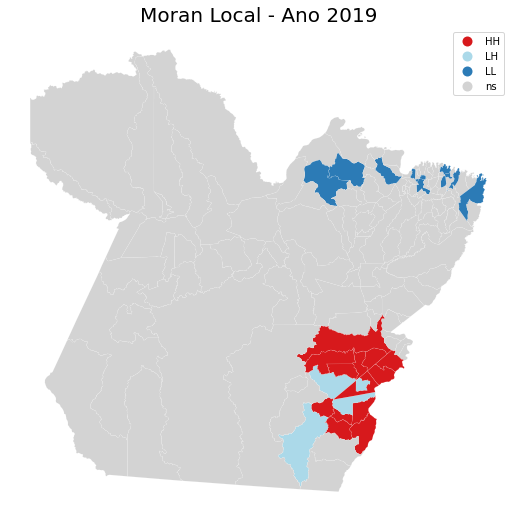

In [81]:
gdf = gpd.GeoDataFrame(para, geometry='geometry', crs="EPSG:4326")
lisa_cluster(moran_loc, gdf, p=0.05, figsize = (9,9))
plt.title('''Moran Local - Ano 2019''', fontdict = {'fontsize':20})
plt.show()

# Combined visualizations

Often, it is easier to asses once statistical results or interpret these results comparing different visualizations.
Here we for example look at a static visualization of a Moran Scatterplot, LISA cluster map and choropleth map.

In [88]:
import warnings
warnings.filterwarnings('ignore')

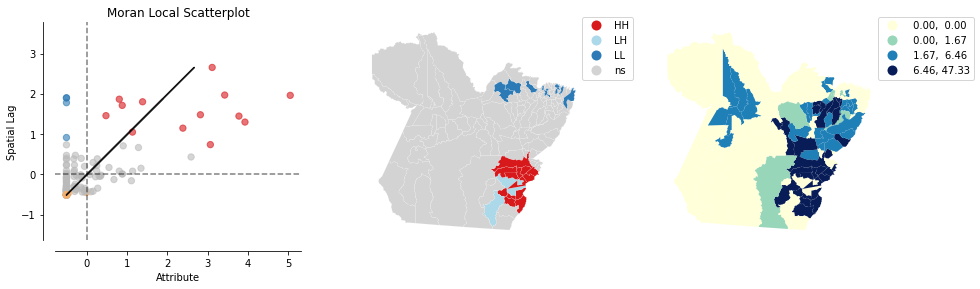

In [89]:
plot_local_autocorrelation(moran_loc, gdf, '2019')
plt.show()

# Bivariate Moran Statistics
Additionally, to assessing the correlation of one variable over space. It is possible to inspect the relationwhip of two variables and their position in space with so called Bivariate Moran Statistics. These can be found in `esda.moran.Moran_BV`.

In [93]:
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv

Next to `y` we will also be looking at the [variable_name] rate `x`.

In [91]:
# podem ser testadas outras variáveis
x = gdf['2018'].values

Before we dive into Bivariate Moran startistics, let's make a quick overview which `esda.moran` objects are supported by `moran_scatterplot`:

In [94]:
moran = Moran(y,w)
moran_bv = Moran_BV(y, x, w)
moran_loc = Moran_Local(y, w)
moran_loc_bv = Moran_Local_BV(y, x, w)

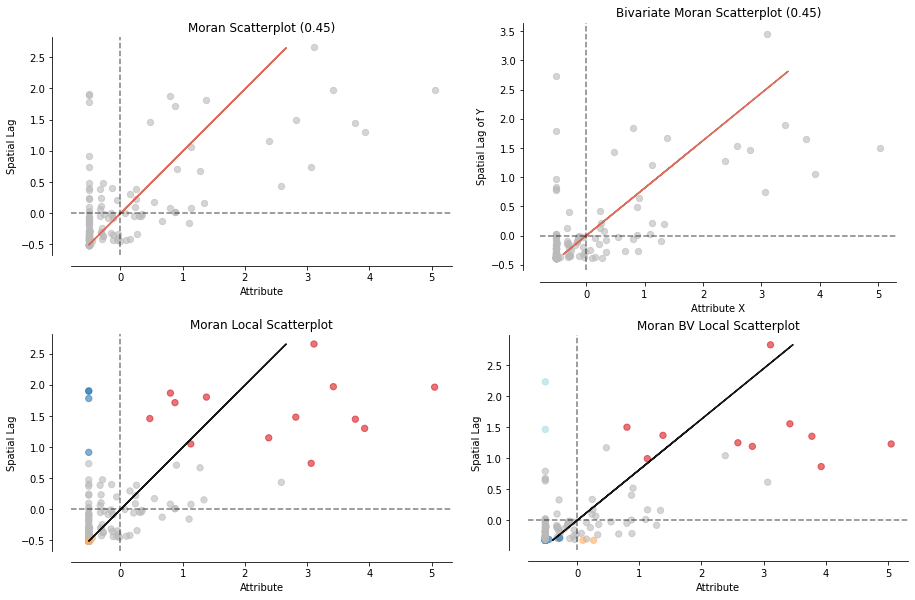

In [95]:
fig, axs = plt.subplots(2, 2, figsize=(15,10),
                        subplot_kw={'aspect': 'equal'})

moran_scatterplot(moran, ax=axs[0,0])
moran_scatterplot(moran_loc, p=0.05, ax=axs[1,0])
moran_scatterplot(moran_bv, ax=axs[0,1])
moran_scatterplot(moran_loc_bv, p=0.05, ax=axs[1,1])
plt.show()

As you can see an easy `moran_scatterplot` call provides you with loads of options. Now what are Bivariate Moran Statistics?

Bivariate Moran Statistics describe the correlation between one variable and the spatial lag of another variable. Therefore, we have to be careful interpreting our results. Bivariate Moran Statistics do not take the inherent correlation between the two variables at the same location into account. They much more offer a tool to measure the degree one polygon with a specific attribute is correlated with its neighboring polygons with a different attribute.

`splot` can offer help interpreting the results by providing visualizations of reference distributions and a Moran Scatterplot:

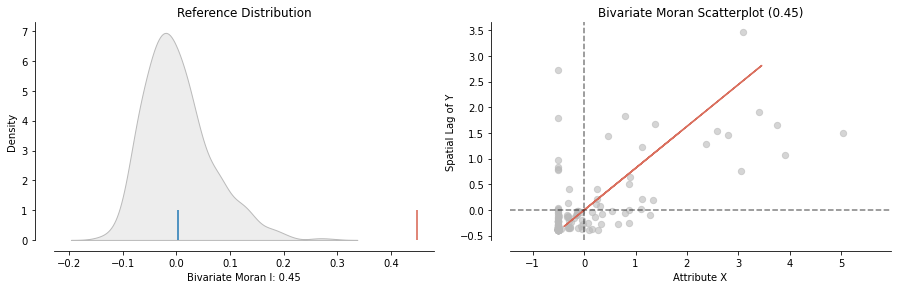

In [96]:
plot_moran_bv(moran_bv, figsize=(15,4))
plt.show()

## Local Bivariate Moran Statistics
Similar to univariate local Moran statistics `pysal` and `splot` offer tools to asses local autocorrelation for bivariate analysis:

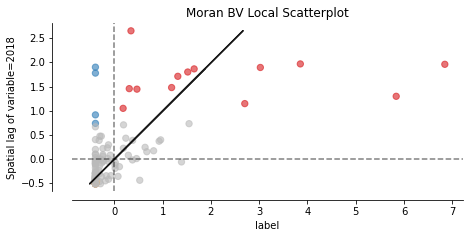

In [97]:
moran_loc_bv = Moran_Local_BV(x, y, w)
fig, ax = moran_scatterplot(moran_loc_bv, p=0.05)
ax.set_xlabel('label')
ax.set_ylabel('Spatial lag of variable=2018')
plt.show()

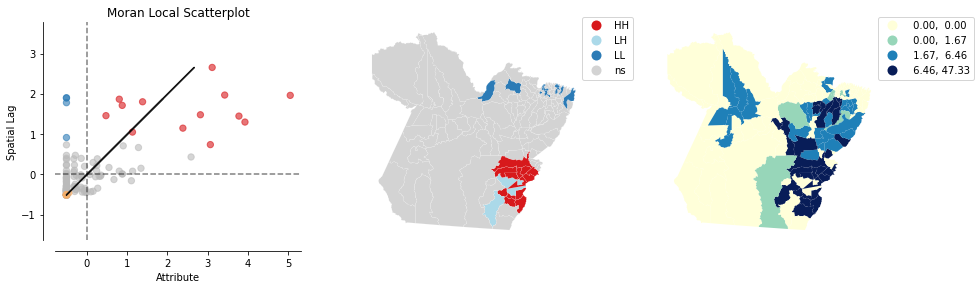

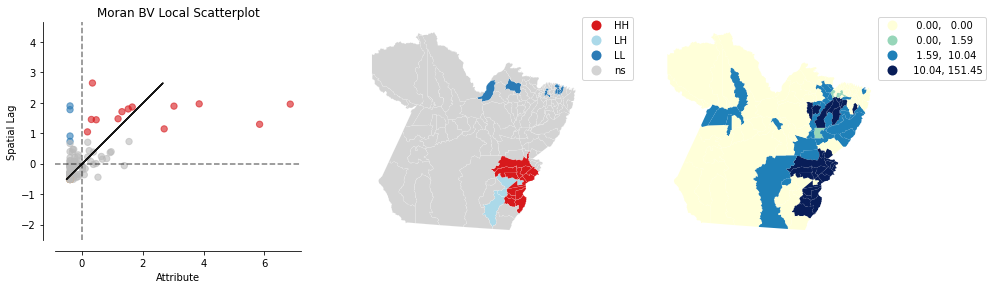

In [119]:
plot_local_autocorrelation(moran_loc, gdf, '2019')
plot_local_autocorrelation(moran_loc_bv, gdf, '2018')
plt.show()